# SciPy Proceedings 2017: "ChiantiPy: A Python Package for Astrophysical Spectroscopy"
This notebook provides the source to build all of the figures for the SciPy 2017 proceedings paper on ChiantiPy.

In [103]:
import os
import glob

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import pandas as pd
import periodictable
import roman

import ChiantiPy.core as ch
import ChiantiPy.tools.util as ch_util
import ChiantiPy.tools.data as ch_data
import ChiantiPy.tools.io as ch_io

sns.set_context('paper',font_scale=1.6,
                rc={
                    'lines.linewidth':2
                })
sns.set_style('white')
%matplotlib inline

## Database

Make a heatmap showing all of the ions in the CHIANTI database and the associated number of levels. Probably best to build a pandas dataframe first.

In [104]:
ion_list = []
exclude_dirs = ['abundance','ancillary_data','continuum','dem','ioneq','ip','masterlist','VERSION']

In [105]:
for top_dir in glob.glob('/usr/local/ssw/packages/chianti/dbase/*'):
    if os.path.basename(top_dir) not in exclude_dirs:
        for sub_dir in glob.glob(os.path.join(top_dir,'*')):
            ion = os.path.basename(sub_dir)
            if ion[-1] == 'd':
                continue
            elvlc = ch_io.elvlcRead(ion)
            if elvlc['status'] == 0:
                continue
            num_levels = np.max(elvlc['lvl'])
            tmp_name = ch_util.zion2spectroscopic(ch_util.el2z(ion.split('_')[0]),int(ion.split('_')[1]))
            element = list(filter(None,tmp_name.split(' ')))[0]
            stage = list(filter(None,tmp_name.split(' ')))[1]
            ion_list.append({'Element':element,'Stage':stage,'Levels':num_levels})

 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/li/li_4/li_4.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/li/li_1/li_1.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/li/li_2/li_2.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/li/li_3/li_3.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/ti/ti_23/ti_23.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/ti/ti_9/ti_9.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/ti/ti_6/ti_6.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/ti/ti_3/ti_3.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/ti/ti_4/ti_4.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/ti/ti_5/ti_5.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages/chianti/dbase/ti/ti_8/ti_8.elvlc
 elvlc file does not exist:  /usr/local/ssw/packages

In [106]:
ion_table = pd.DataFrame(ion_list)
ion_table_pivot = ion_table.pivot('Element','Stage','Levels')
new_indices = sorted(ion_table_pivot.index, key=lambda x:periodictable.elements.symbol(x).number)
ion_table_pivot = ion_table_pivot.reindex(new_indices)
ion_table_pivot = ion_table_pivot.reindex_axis(sorted(ion_table_pivot.columns.tolist(),key=lambda x:roman.fromRoman(x)),axis=1)

/home/wtb2/anaconda3/envs/chiantipy/lib/python3.5/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


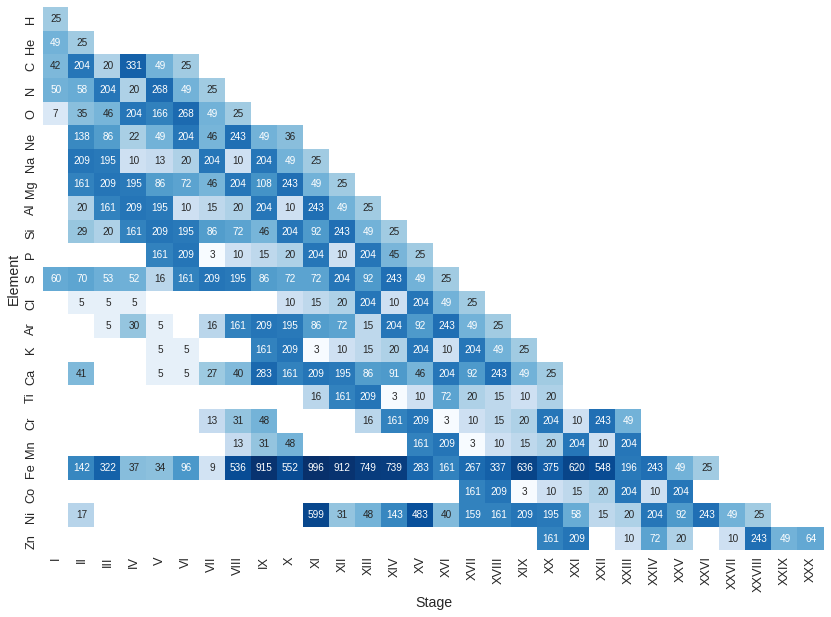

In [113]:
fig = plt.figure(figsize=(14,10))
my_cmap = plt.get_cmap('Blues')
my_cmap.set_bad(color='w')
sns.heatmap(ion_table_pivot,ax=fig.gca(),square=False,cmap=my_cmap,
            annot=True,fmt='.0f',
            norm=matplotlib.colors.LogNorm(vmin=1,vmax=1e3),
            cbar_kws={'ticks':[1,10,100,1000]},
            cbar=False
           )
plt.savefig('figures/linelist.pdf',dpi=1000,format='pdf')

In [39]:
foo = ch_io.wgfaRead('fe_5')
bar = ch_io.elvlcRead('fe_5')

In [46]:
foo.keys()

dict_keys(['pretty2', 'lvl1', 'avalue', 'wvl', 'ref', 'lvl2', 'gf', 'pretty1', 'ionS', 'filename'])

In [57]:
def linear_fit(x,a,b):
    return b*x**a

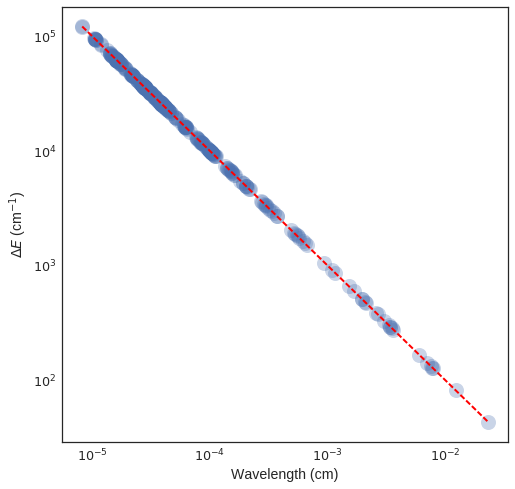

In [74]:
foo = ch_io.wgfaRead(tmp_ion)
bar = ch_io.elvlcRead(tmp_ion)
delta_energies = np.array(bar['ecm'])[np.array(foo['lvl2'],np.int) - 1] - np.array(bar['ecm'])[np.array(foo['lvl1'],np.int) - 1]
wvl_cm = np.array(foo['wvl'])/1e8
wvl_smooth = np.linspace(wvl_cm.min(),wvl_cm.max(),100)
#delta_energys *= ch_data.
popt,pcov = curve_fit(linear_fit,wvl_cm,delta_energies)
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.plot(wvl_cm,delta_energies,'o',label=tmp_ion,markersize=15,alpha=0.3)
ax.plot(wvl_smooth,linear_fit(wvl_smooth,*popt),'--r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$\Delta E$ (cm$^{-1}$)')
ax.set_xlabel(r'Wavelength (cm)')

In [17]:
spd_ticklabels = sorted(set([(a,b) for a,b in zip(bar['l'],bar['spd'])]),key=lambda x:x[0])

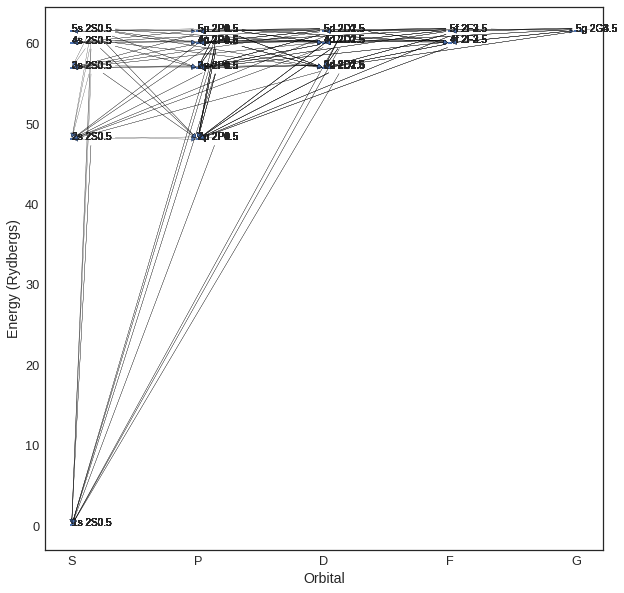

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
for i in range(len(foo['wvl'])):
    l1,e1 = bar['l'][foo['lvl1'][i]-1],bar['eryd'][foo['lvl1'][i]-1]
    l2,e2 = bar['l'][foo['lvl2'][i]-1],bar['eryd'][foo['lvl2'][i]-1]
    ax.scatter(l1,e1,
               marker='_',color=sns.color_palette('deep')[0],s=10)
    ax.scatter(l2,e2,
               marker='_',color=sns.color_palette('deep')[0],s=10)
    ax.annotate(foo['pretty2'][i],
                xy=(l1,e1), xycoords='data',
                xytext=(l2,e2), textcoords='data',
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3"),)
    ax.text(l1,e1,foo['pretty1'][i])
ax.set_xticks([x[0] for x in spd_ticklabels])
ax.set_xticklabels([x[1] for x in spd_ticklabels])
#ax.set_ylim([1.3,2])
ax.set_xlabel(r'Orbital')
ax.set_ylabel(r'Energy (Rydbergs)')

## Emissivity and Level Populations

Show plot of populations for a sample ion and a plot of emissivities for a sample ion. These should be as a function of wavelength and temperature/density. We'll probably just use Fe for all of the examples to make things easy.

## Contribution Functions
First, the contribution function function in the ion class needs to be refactored. But then we should show the contribution function for a couple of ions.

## Continuum Emission
Free-free, free-bound, two-photon

## Ionization Equilibrium
Include some equations that describe the ionization equilibrium, mention NEI (maybe). Brief example of how this is done. Could also use a refactor...

In [75]:
fe_ioneq = ch.ioneq(26)
temperature = np.logspace(3.5,9.5,500)
fe_ioneq.calculate(temperature)

 Z    26 Stage     1  ionStr fe_1
 Z    26 Stage     2  ionStr fe_2
 Z    26 Stage     3  ionStr fe_3
 Z    26 Stage     4  ionStr fe_4
 Z    26 Stage     5  ionStr fe_5
 Z    26 Stage     6  ionStr fe_6
 Z    26 Stage     7  ionStr fe_7
 Z    26 Stage     8  ionStr fe_8
 Z    26 Stage     9  ionStr fe_9
 Z    26 Stage    10  ionStr fe_10
 Z    26 Stage    11  ionStr fe_11
 Z    26 Stage    12  ionStr fe_12
 Z    26 Stage    13  ionStr fe_13
 Z    26 Stage    14  ionStr fe_14
 Z    26 Stage    15  ionStr fe_15
 Z    26 Stage    16  ionStr fe_16
 Z    26 Stage    17  ionStr fe_17
 Z    26 Stage    18  ionStr fe_18
 Z    26 Stage    19  ionStr fe_19
 Z    26 Stage    20  ionStr fe_20
 Z    26 Stage    21  ionStr fe_21
 Z    26 Stage    22  ionStr fe_22
 Z    26 Stage    23  ionStr fe_23
 Z    26 Stage    24  ionStr fe_24
 Z    26 Stage    25  ionStr fe_25
 Z    26 Stage    26  ionStr fe_26
 Z    26 Stage    27  ionStr fe_27


/home/wtb2/anaconda3/envs/chiantipy/lib/python3.5/site-packages/ChiantiPy-0.7.dev464-py3.5.egg/ChiantiPy/core/Ion.py:3864: RuntimeWarning: divide by zero encountered in double_scalars
  rat = anIon.IonizRate['rate'][it]/anIon.RecombRate['rate'][it]
/home/wtb2/anaconda3/envs/chiantipy/lib/python3.5/site-packages/ChiantiPy-0.7.dev464-py3.5.egg/ChiantiPy/core/Ion.py:3865: RuntimeWarning: divide by zero encountered in double_scalars
  factor.append(rat**2 + rat**(-2))


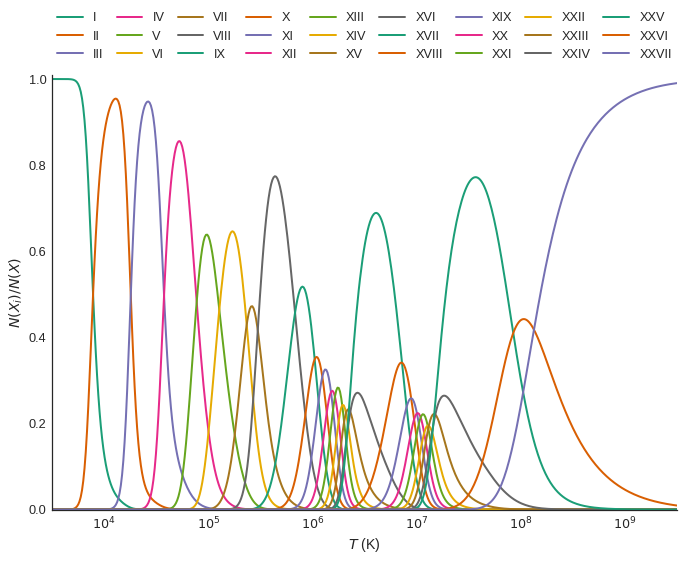

In [81]:
fig = plt.figure(figsize=(11.2,8))
ax = fig.gca()
colors = sns.color_palette('Dark2',n_colors=fe_ioneq.Ioneq.shape[0])
for i in range(fe_ioneq.Ioneq.shape[0]):
    ax.plot(temperature,fe_ioneq.Ioneq[i,:],
            label=roman.toRoman(i+1),
            color=colors[i]
           )
ax.set_xscale('log')
ax.set_ylim([0,1.01])
ax.set_xlabel(r'$T$ (K)')
ax.set_ylabel(r'$N(X_i)/N(X)$')
ax.set_xlim([temperature[0],temperature[-1]])
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=9)
sns.despine(fig=fig,ax=ax)

In [101]:
ioneqs = {}
els = ['H','Na','S','Fe']
for el in els:
    tmp_ioneq = ch.ioneq(ch_util.el2z(el))
    tmp_ioneq.calculate(temperature)
    ioneqs[el] = tmp_ioneq.Ioneq

 Z     1 Stage     1  ionStr h_1
 Z     1 Stage     2  ionStr h_2
 Z    11 Stage     1  ionStr na_1
 Z    11 Stage     2  ionStr na_2


/home/wtb2/anaconda3/envs/chiantipy/lib/python3.5/site-packages/ChiantiPy-0.7.dev464-py3.5.egg/ChiantiPy/core/Ion.py:3864: RuntimeWarning: divide by zero encountered in double_scalars
  rat = anIon.IonizRate['rate'][it]/anIon.RecombRate['rate'][it]
/home/wtb2/anaconda3/envs/chiantipy/lib/python3.5/site-packages/ChiantiPy-0.7.dev464-py3.5.egg/ChiantiPy/core/Ion.py:3865: RuntimeWarning: divide by zero encountered in double_scalars
  factor.append(rat**2 + rat**(-2))


 Z    11 Stage     3  ionStr na_3
 Z    11 Stage     4  ionStr na_4
 Z    11 Stage     5  ionStr na_5
 Z    11 Stage     6  ionStr na_6
 Z    11 Stage     7  ionStr na_7
 Z    11 Stage     8  ionStr na_8
 Z    11 Stage     9  ionStr na_9
 Z    11 Stage    10  ionStr na_10
 Z    11 Stage    11  ionStr na_11
 Z    11 Stage    12  ionStr na_12
 Z    16 Stage     1  ionStr s_1
 Z    16 Stage     2  ionStr s_2
 Z    16 Stage     3  ionStr s_3
 Z    16 Stage     4  ionStr s_4
 Z    16 Stage     5  ionStr s_5
 Z    16 Stage     6  ionStr s_6
 Z    16 Stage     7  ionStr s_7
 Z    16 Stage     8  ionStr s_8
 Z    16 Stage     9  ionStr s_9
 Z    16 Stage    10  ionStr s_10
 Z    16 Stage    11  ionStr s_11
 Z    16 Stage    12  ionStr s_12
 Z    16 Stage    13  ionStr s_13
 Z    16 Stage    14  ionStr s_14
 Z    16 Stage    15  ionStr s_15
 Z    16 Stage    16  ionStr s_16
 Z    16 Stage    17  ionStr s_17
 Z    26 Stage     1  ionStr fe_1
 Z    26 Stage     2  ionStr fe_2
 Z    26 Stage     3

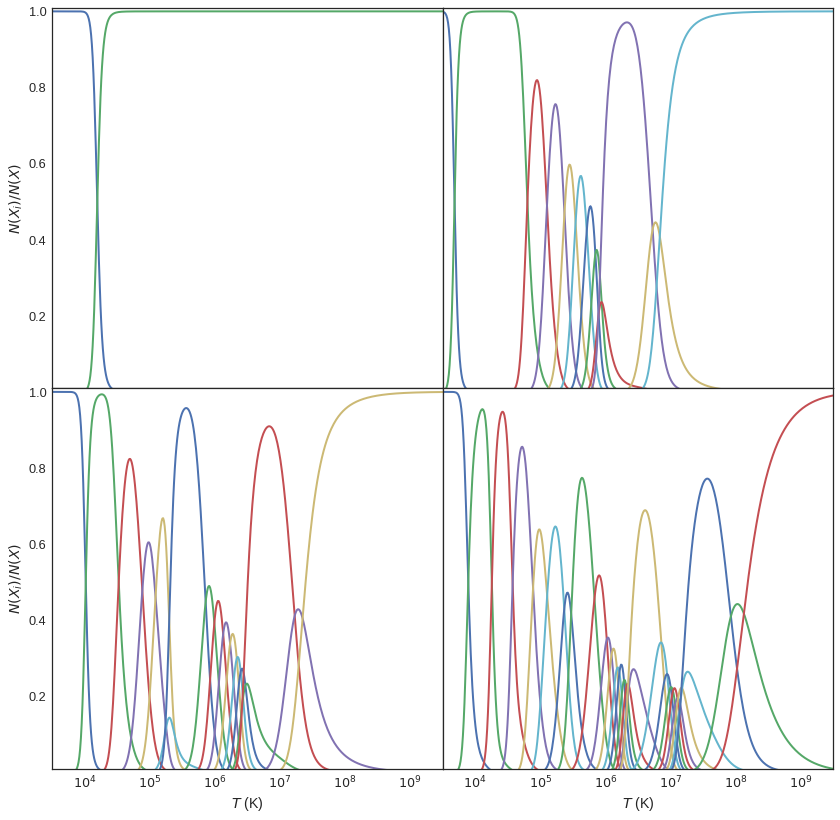

In [115]:
fig,axes = plt.subplots(2,2,figsize=(14,14),sharex=True,sharey=True)
for ax,el in zip(axes.flatten(),els):
    for i in range(ioneqs[el].shape[0]):
        ax.plot(temperature,ioneqs[el][i,:])
    ax.set_xscale('log')
    ax.set_ylim([0.01,1.01])
    ax.set_xlim([temperature[0],temperature[-1]])
    if axes.flatten().tolist().index(ax) > 1:
        ax.set_xlabel(r'$T$ (K)')
    if axes.flatten().tolist().index(ax)%2 == 0:
        ax.set_ylabel(r'$N(X_i)/N(X)$')
plt.subplots_adjust(hspace=0,wspace=0)
plt.savefig('figures/ioneq.pdf',dpi=1000,format='pdf')

## Radiative Losses

## Spectra